# Computing Axial Solar Magnetic Dipole Moment by Utilizing SDO/HMI Magnetograms

### This notebook computes dipole moment particularly for SDO/HMI radial magnetograms that are pre-downloaded from [http://jsoc.stanford.edu/](http://jsoc.stanford.edu/).

## Technicalities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sunpy
import sunpy.map as m
from sunpy.net.jsoc.jsoc import drms
from sunpy.visualization import drawing
import warnings
from astropy.io import fits
import glob
import datetime

In [2]:
warnings.filterwarnings('ignore')

In [3]:
params = {'axes.labelsize'  : 13,
          'xtick.labelsize' : 12,
          'ytick.labelsize' : 12,
          'font.family'     : 'DejaVu serif',
          'font.serif'      : "Laro"
         }

matplotlib.rcParams.update(params)

In [4]:
#path to working directory
main_dir = 'c:/Users/priya/Work/projects/SC25 prediction/Github content/'

### Visualizing a magnetogram corresponding to the carrington rotation 2106

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


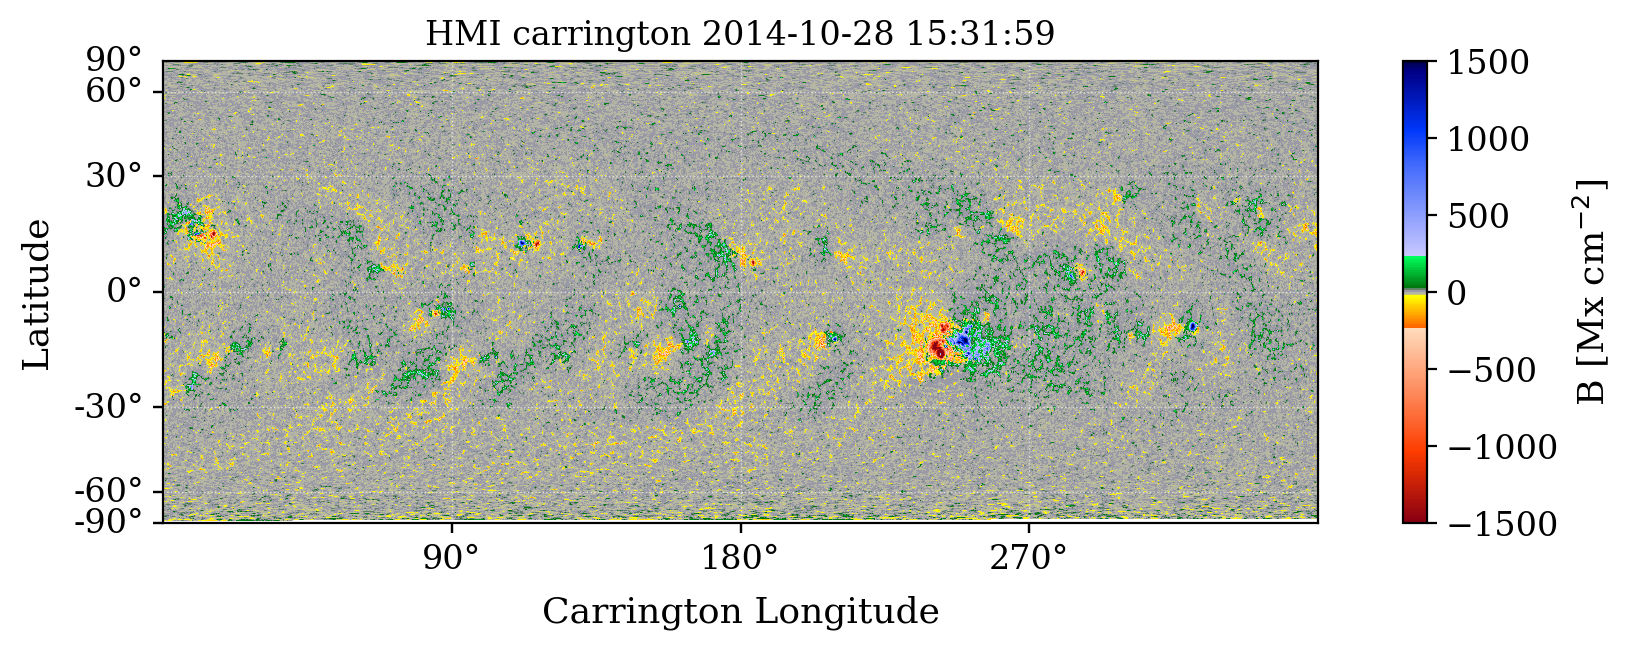

In [5]:
#reading the data from fits file corresponding to carrington rotation 2156
synoptic_map = m.Map(main_dir + 'HMI_data/hmi.Synoptic_Mr_720s.2156.synopMr.fits')

#plotting
fig = plt.figure(figsize = (11, 3), dpi = 200)

ax = fig.add_subplot(projection = synoptic_map)
synoptic_map.plot(axes = ax)

plt.clim(-1500, 1500)
plt.colorbar(label = r'B [Mx cm$^{-2}$]') #units can be found via -> synoptic_maps[50].meta['bunit']
plt.show()

### Reading all the fits file as sunpy maps into a list

The radial magnetograms span from carrington rotation (CR) 2106 to 2273

In [6]:
#path to pre-downloaded data from jsoc
files = glob.glob(main_dir + 'HMI_data/*')

print('Total number of files =', len(files))

Total number of files = 168


In [7]:
#reading all 168 fits file as sunpy maps
synoptic_maps = []

for i in range(len(files)):
    synoptic_maps.append(m.Map(files[i]))

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


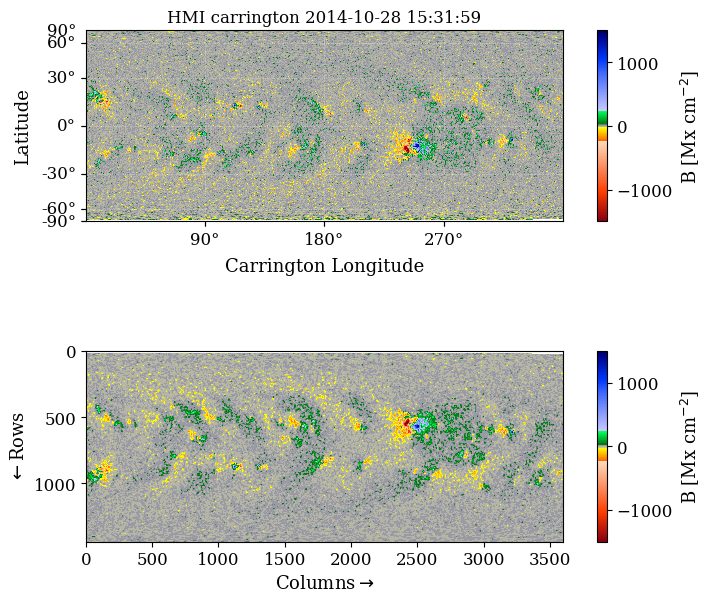

In [8]:
#plotting same synoptic map in two different ways
fig = plt.figure(figsize = (9, 7))

#plotting sunpy map
map_50 = m.Map(synoptic_maps[50])
ax = fig.add_subplot(2, 1, 1, projection = map_50)
map_50.plot(axes = ax)
plt.clim(-1500, 1500)
plt.colorbar(label = r'B [Mx cm$^{-2}$]')


#plotting the data map explicitly extracted from sunpy map
plt.subplot(2, 1, 2)
plt.imshow(synoptic_maps[50].data, cmap = 'hmimag')
plt.xlabel(r'Columns$\rightarrow$', fontsize = 13)
plt.ylabel(r'$\leftarrow$Rows', fontsize = 13)
plt.clim(-1500, 1500)
plt.colorbar(label = r'B [Mx cm$^{-2}$]')

fig.tight_layout(pad = 5)
plt.show()

### $\Large{🛑}$ 
#### Explicitly plotting the data from sunpy map results in an upside down inversion of the matrix. This is to be taken care of if one is using sunpy_map.data for visualization or calculation purposes.

## Calculating Axial Dipole Moment

Utilizing the synoptic charts, the dipole moment of the Sun can be calculated using the following expression,
</br>
</br>

<center> $D(t) = \frac{3}{2} \int_{0}^{\pi} \overline{B}(\theta, t) \cos{\theta} \sin{\theta}\ d\theta$ </center>

where, $\overline{B}$ is the azimuthally averaged magnetic field and $\theta$ is the colatitude on the surface of the Sun.

Refer to [Jaswal et al_2024_MNRASL](https://doi.org/10.1093/mnrasl/slad122) and references therein for the expression of $D(t)$

### Azimuthally averaging the magnetic field over the whole longitudinal range for each map

In [9]:
synoptic_maps_data = []
B_phiavg = []

for i in synoptic_maps:
    synoptic_maps_data.append(np.nan_to_num(np.flipud(i.data)))   #np.nan_to_num converts nan values to 0
                                                                  #so that the azimuthal average can be computed
for i in synoptic_maps_data:
    B_phiavg.append(i.sum(axis = 1))

In [10]:
cos_th = np.linspace(np.cos(0), np.cos(np.pi), 1440)
sin_th = np.sqrt(1 - cos_th * cos_th)

print('cos theta =', cos_th, '\n')
print('sin theta =', sin_th)

cos theta = [ 1.          0.99861015  0.99722029 ... -0.99722029 -0.99861015
 -1.        ] 

sin theta = [0.         0.05270461 0.07450966 ... 0.07450966 0.05270461 0.        ]


In [11]:
integrand = []

for i in B_phiavg:
    integrand.append(np.asarray(i * cos_th * sin_th))

### Performing integration using Simpson's 3/8 rule

In [12]:
h = np.pi / len(integrand[0])   #number of rows in the magnetogram data = len(integrand[i]) = 1440

weight = [1, 3, 3, 1]

DM = np.zeros(len(integrand))

for j in range(len(DM)):
    integral = 0
    
    for i in np.arange(0, 479, 3):
        integral = integral + np.mean([(integrand[j][0 : -2][i : i + 4] * weight).sum(),
                                       (integrand[j][1 : -1][i : i + 4] * weight).sum(),
                                       (integrand[j][2 : ][i : i + 4]   * weight).sum()])
    DM[j] = (3 / 2) * (3 * (h / 8)) * integral

### Creating time array corresponding to the dipole moment calculated from respective magnetograms

In [13]:
t_obs = []

for i in synoptic_maps[0 : 107]:
    t_obs.append(datetime.datetime.strptime(i.meta['t_obs'], '%Y.%m.%d_%H:%M:%S_TAI'))

t_obs.append(datetime.datetime.strptime('2019.01.30_12:01:00_TAI', '%Y.%m.%d_%H:%M:%S_TAI'))

for i in synoptic_maps[108 : ]:
    t_obs.append(datetime.datetime.strptime(i.meta['t_obs'], '%Y.%m.%d_%H:%M:%S_TAI'))

In [14]:
synoptic_maps[107].meta['t_obs']  # seconds should be less than 59

'2019.01.30_12:00:60_TAI'

### Visualizing the dipole moment

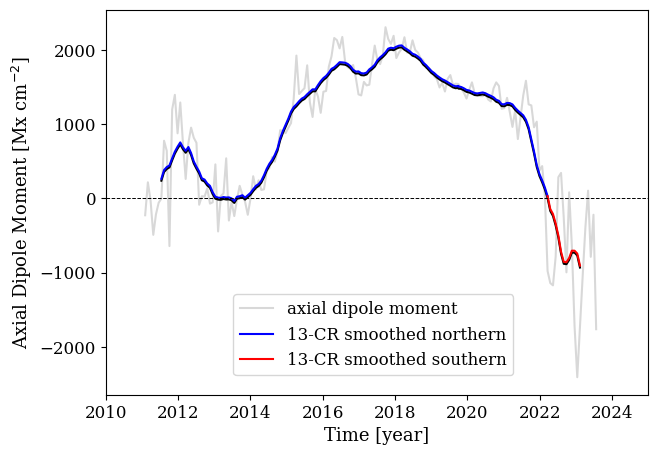

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))

f = 150

ax.plot(t_obs, DM, color = 'grey', alpha = 0.3, label = 'axial dipole moment')

ax.plot(t_obs, pd.Series(DM).rolling(13, center = True).mean() - 26, color = 'k')

ax.plot(t_obs[ : f], pd.Series(DM).rolling(13, center = True).mean()[ : f], color = 'b', label = '13-CR smoothed northern')
ax.plot(t_obs[f - 1 : ], pd.Series(DM).rolling(13, center = True).mean()[f - 1 : ], color = 'r', label = '13-CR smoothed southern')


ax.set_xlabel('Time [year]')
ax.set_ylabel('Axial Dipole Moment [Mx cm$^{-2}$]')
ax.set_xlim(datetime.datetime(2010, 1, 1), datetime.datetime(2025, 1, 1))

ax.axhline(0, ls = '--', color = 'k', lw = 0.7)

ax.legend(ncols = 1, loc= (0.235, 0.05), fontsize = 12)  #(1.04, 0.7)
plt.show()

## Plotting Total Sunspot Number and Axial Dipole Moment Time Series simultaneously

### Reading total sunspot number data

Refer to [https://www.sidc.be/SILSO/datafiles](https://www.sidc.be/SILSO/datafiles) for total sunspot number data

In [16]:
data_SSN = pd.read_csv(main_dir + 'data/SN_ms_tot_V2.0.txt', header = None, delim_whitespace = True)
SSN = data_SSN.loc[:, 3]

In [17]:
time_SSN = []

for i in range(len(data_SSN)):
    time_SSN.append(datetime.datetime(year = data_SSN.loc[i, 0], month = data_SSN.loc[i, 1], day = 1))
    
    #format of datetime object -> datetime.datetime(year = 2018, month = 9, day = 1)

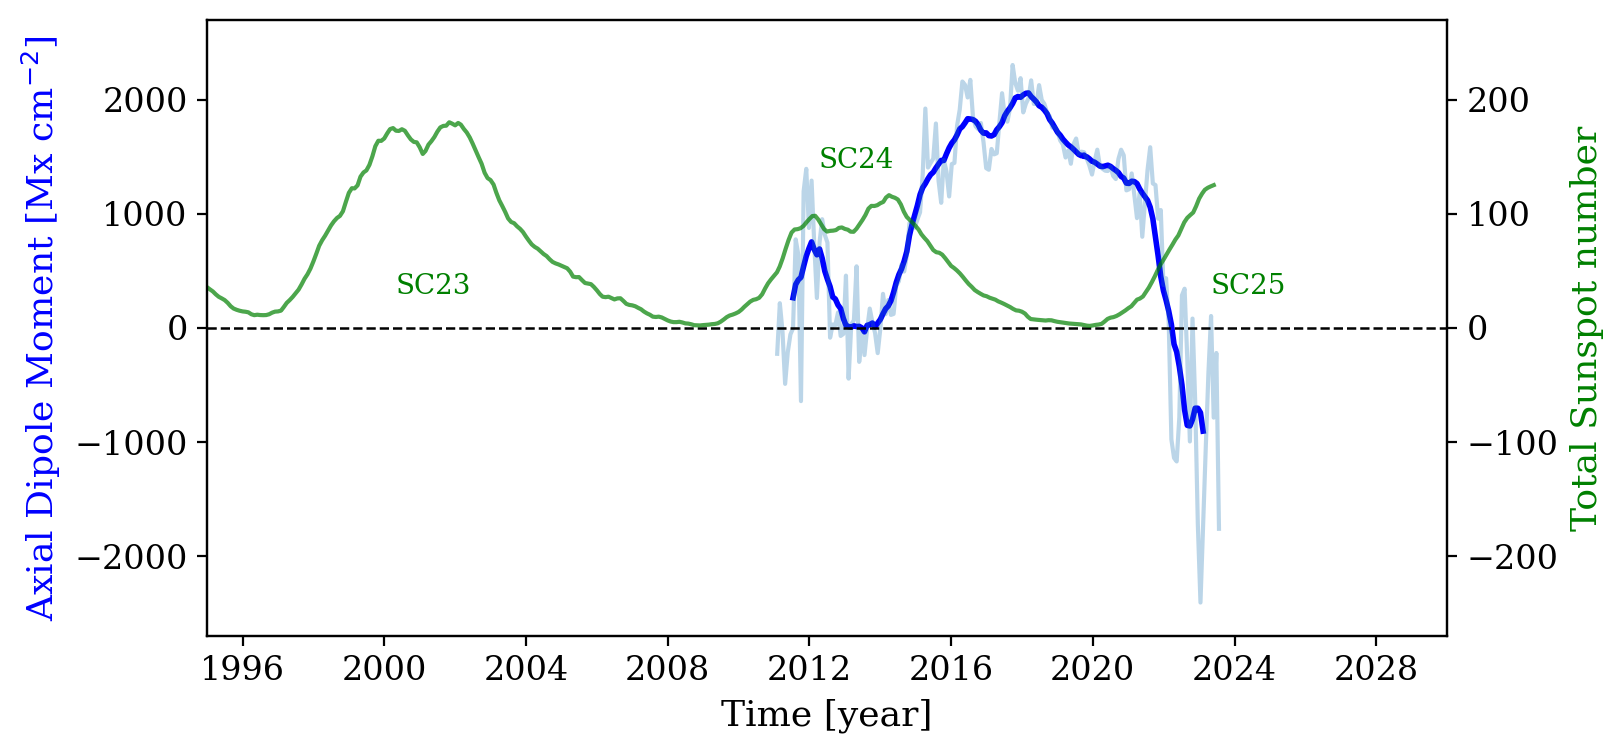

In [18]:
fig, ax = plt.subplots(1, 1, figsize = (8, 4), dpi = 200)

t = np.arange(synoptic_maps[0].meta['car_rot'], synoptic_maps[-1].meta['car_rot'] + 1)
ax.plot(t_obs, DM, alpha = 0.3)
ax.plot(t_obs, pd.Series(DM).rolling(13, center = True).mean(), color = 'b', lw = 2, zorder = 0)
ax.axhline(y = 0, lw = 0.9, ls = '--', color = 'k')
ax.set_xlabel('Time [year]')
ax.set_ylabel('Axial Dipole Moment [Mx cm$^{-2}$]', color = 'b')
ax.set_ylim(-2700, 2700)

ax1 = ax.twinx()
ax1.plot(time_SSN, SSN, color = 'green', alpha = 0.7, zorder = 1)
ax1.set_ylim(-270, 270)
ax1.set_ylabel('Total Sunspot number', color = 'green')
ax1.text(datetime.datetime(2000, 5, 1), 30, 'SC23', color = 'g', zorder = 2)
ax1.text(datetime.datetime(2012, 4, 1), 140, 'SC24', color = 'g', zorder = 2)
ax1.text(datetime.datetime(2023, 5, 1), 30, 'SC25', color = 'g', zorder = 2)
plt.xlim(datetime.datetime(1995, 1, 1), datetime.datetime(2030, 1, 1))
         
# plt.savefig(main_dir + 'figures/plot.png', bbox_inches = 'tight', dpi = 1500)
         
plt.show()